In [71]:
# Reference from  
# https://becominghuman.ai/part-of-speech-tagging-tutorial-with-the-keras-deep-learning-library-d7f93fa05537

In [72]:
import numpy as np

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [73]:
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [74]:
from nltk.corpus import treebank
sentences = treebank.tagged_sents(tagset='universal')

In [75]:
import random
print(random.choice(sentences))

[('In', 'ADP'), ('her', 'PRON'), ('wake', 'NOUN'), ('she', 'PRON'), ('left', 'VERB'), ('the', 'DET'), ('bitterness', 'NOUN'), ('and', 'CONJ'), ('anger', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('principal', 'NOUN'), ('who', 'PRON'), ('*T*-81', 'X'), ('was', 'VERB'), ('her', 'PRON'), ('friend', 'NOUN'), ('and', 'CONJ'), ('now', 'ADV'), ('calls', 'VERB'), ('her', 'PRON'), ('a', 'DET'), ('betrayer', 'NOUN'), (';', '.'), ('of', 'ADP'), ('colleagues', 'NOUN'), ('who', 'PRON'), ('*T*-82', 'X'), ('say', 'VERB'), ('0', 'X'), ('she', 'PRON'), ('brought', 'VERB'), ('them', 'PRON'), ('shame', 'NOUN'), (';', '.'), ('of', 'ADP'), ('students', 'NOUN'), ('and', 'CONJ'), ('parents', 'NOUN'), ('who', 'PRON'), ('*T*-83', 'X'), ('defended', 'VERB'), ('her', 'PRON'), ('and', 'CONJ'), ('insist', 'VERB'), ('0', 'X'), ('she', 'PRON'), ('was', 'VERB'), ('treated', 'VERB'), ('*-1', 'X'), ('harshly', 'ADV'), (';', '.'), ('and', 'CONJ'), ('of', 'ADP'), ('school-district', 'NOUN'), ('officials', 'NOUN'), ('stunned'

In [76]:
tags = set([
    tag for sentence in treebank.tagged_sents() 
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags))

nb_tags: 46ntags: {'WP', 'NNS', 'VBN', 'JJR', 'VBZ', 'FW', '#', 'NN', 'SYM', 'JJ', 'IN', 'PRP', 'RB', '.', 'UH', 'PRP$', ',', 'TO', '$', '-NONE-', '-LRB-', '``', "''", 'VBG', 'RP', 'POS', '-RRB-', 'LS', 'RBS', 'WRB', 'DT', 'JJS', 'PDT', 'CD', ':', 'NNP', 'VB', 'WP$', 'MD', 'CC', 'VBD', 'VBP', 'EX', 'RBR', 'WDT', 'NNPS'}


In [77]:
train_test_cutoff = int(.80 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]

testing_sentences = sentences[train_test_cutoff:]
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

In [78]:
def add_basic_features(sentence_terms, index):
  term = sentence_terms[index];
  return {
    'nb_terms': len(sentence_terms),
    'term': term,
    'is_first': index == 0,
    'is_last': index == len(sentence_terms) - 1,
    'is_capitalized': term[0].upper() == term[0],
    'is_all_caps': term.upper() == term,
    'is_all_lower': term.lower() == term,
    'prefix-1': term[0],
    'prefix-2': term[:2],
    'prefix-3': term[:3],
    'suffix-1': term[-1],
    'suffix-2': term[-2:],
    'suffix-3': term[-3:],
    'prev_word': '' if index == 0 else sentence_terms[index - 1],
    'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
  }

In [79]:
#lay cau 
def untag(tagged_sentence):
  return [w for w, _ in tagged_sentence];

In [80]:
def transform_to_dataset(tagged_sentences):
  X, y = [], []
  for pos_tags in tagged_sentences:
    for index, (term, class_) in enumerate(pos_tags):
      X.append(add_basic_features(untag(pos_tags), index))
      y.append(class_)
  return X, y

In [81]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

In [82]:
print(X_train[0])
print(y_train[7])

{'nb_terms': 28, 'term': 'Mrs.', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'M', 'prefix-2': 'Mr', 'prefix-3': 'Mrs', 'suffix-1': '.', 'suffix-2': 's.', 'suffix-3': 'rs.', 'prev_word': '', 'next_word': 'Ward'}
VERB


In [83]:
from sklearn.feature_extraction import DictVectorizer# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=True)
dict_vectorizer.fit(X_train + X_test + X_val)# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

In [84]:
from sklearn.preprocessing import LabelEncoder# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [85]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [86]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
  model = Sequential([
    Dense(hidden_neurons, input_dim=input_dim),
    Activation('relu'),
    Dropout(0.2),
    Dense(hidden_neurons),
    Activation('relu'),
    Dropout(0.2),
    Dense(output_dim, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [87]:
from keras.wrappers.scikit_learn import KerasClassifier
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}
clf = KerasClassifier(**model_params)

In [88]:


hist = clf.fit(X_train, y_train)


Epoch 1/5
239/239 [==============================] - 22s 93ms/step - loss: 0.3995 - accuracy: 0.8839 - val_loss: 0.1790 - val_accuracy: 0.9366
Epoch 2/5
239/239 [==============================] - 22s 92ms/step - loss: 0.0752 - accuracy: 0.9754 - val_loss: 0.1590 - val_accuracy: 0.9537
Epoch 3/5
239/239 [==============================] - 22s 92ms/step - loss: 0.0428 - accuracy: 0.9860 - val_loss: 0.1408 - val_accuracy: 0.9597
Epoch 4/5
239/239 [==============================] - 22s 92ms/step - loss: 0.0251 - accuracy: 0.9922 - val_loss: 0.1531 - val_accuracy: 0.9590
Epoch 5/5
239/239 [==============================] - 22s 92ms/step - loss: 0.0199 - accuracy: 0.9933 - val_loss: 0.1490 - val_accuracy: 0.9601


In [89]:
import matplotlib.pyplot as plt
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """    
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

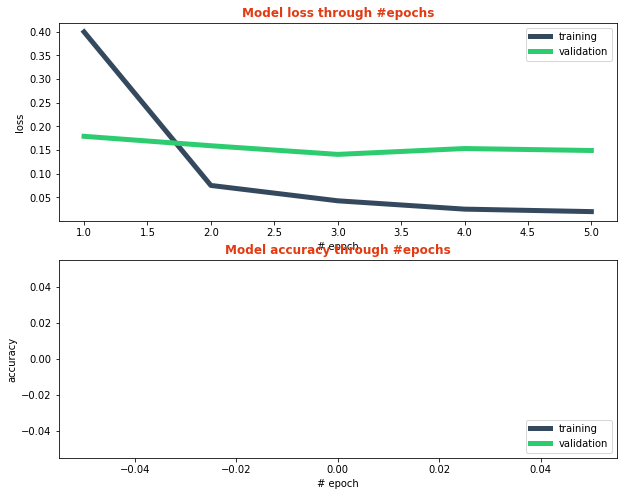

In [90]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

In [91]:
score = clf.score(X_test, y_test)
print(score)

79/79 [==============================] - 0s 6ms/step - loss: 0.1039 - accuracy: 0.9690
0.9690104126930237


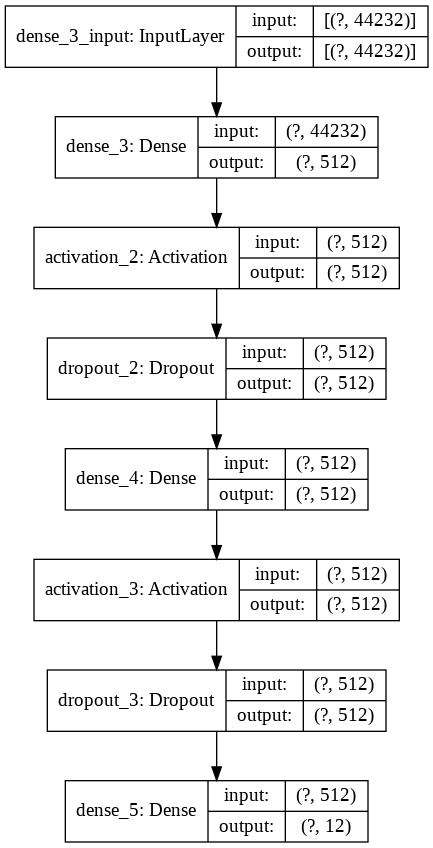

In [92]:
from keras.utils import plot_model

plot_model(clf.model, to_file='model.png', show_shapes=True)